In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve

import statsmodels.api as sm

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [27]:
bike_rental = pd.read_csv('https://raw.githubusercontent.com/huanfachen/Spatial_Data_Science/main/Dataset/daily_count_bike_rental.csv')
# drop the year variable as it is not useful
bike_rental = bike_rental.drop (['yr'],axis=1)
bike_rental.head()

,cnt,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
0,985,SPRING,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.1758,80.5833,10.7499,0
1,801,SPRING,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.0835,69.6087,16.6521,1
2,1349,SPRING,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.2291,43.7273,16.6367,2
3,1562,SPRING,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.4000,59.0435,10.7398,3
4,1600,SPRING,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.6670,43.6957,12.5223,4


In [28]:
# Converting categorical variables
bike_rentail_numeric = pd.get_dummies(bike_rental)
# check out the new dataFrame
bike_rentail_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cnt                         731 non-null    int64  
 1   temp                        731 non-null    float64
 2   hum                         731 non-null    float64
 3   windspeed                   731 non-null    float64
 4   days_since_2011             731 non-null    int64  
 5   season_FALL                 731 non-null    bool   
 6   season_SPRING               731 non-null    bool   
 7   season_SUMMER               731 non-null    bool   
 8   season_WINTER               731 non-null    bool   
 9   mnth_APR                    731 non-null    bool   
 10  mnth_AUG                    731 non-null    bool   
 11  mnth_DEZ                    731 non-null    bool   
 12  mnth_FEB                    731 non-null    bool   
 13  mnth_JAN                    731 non

In [31]:
# drop unneeded column, using axis=1 (referring to columns)
bike_rental_final = bike_rentail_numeric.drop(['season_SPRING', 'mnth_JAN', 'holiday_NO HOLIDAY', 'weekday_MON', 'workingday_WORKING DAY', 'weathersit_GOOD'], axis=1)

# double check the result
bike_rental_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cnt                         731 non-null    int64  
 1   temp                        731 non-null    float64
 2   hum                         731 non-null    float64
 3   windspeed                   731 non-null    float64
 4   days_since_2011             731 non-null    int64  
 5   season_FALL                 731 non-null    bool   
 6   season_SUMMER               731 non-null    bool   
 7   season_WINTER               731 non-null    bool   
 8   mnth_APR                    731 non-null    bool   
 9   mnth_AUG                    731 non-null    bool   
 10  mnth_DEZ                    731 non-null    bool   
 11  mnth_FEB                    731 non-null    bool   
 12  mnth_JUL                    731 non-null    bool   
 13  mnth_JUN                    731 non

In [34]:
random_state_split = 100
train_x, test_x, train_y, test_y = train_test_split (bike_rental_final.drop(['cnt'], axis=1), bike_rental_final.cnt, random_state=random_state_split)

In [35]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical. The index indicates which rows from the original data.

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(548, 28)
(548,)
(183, 28)
(183,)
True
True


Regression tree

In [37]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(random_state=0)
reg_tree.fit(train_x, train_y)

DecisionTreeRegressor(random_state=0)

In [38]:
print("R2 on the training data:")
print(reg_tree.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(reg_tree.score(X=test_x, y=test_y))

R2 on the training data:
1.0
R2 on the testing data:
0.7229453566227575


In [40]:
from sklearn.metrics import mean_squared_error
print("RMSE on the training data:")
print(mean_squared_error(train_y, reg_tree.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, reg_tree.predict(test_x), squared=False))

RMSE on the training data:
0.0
RMSE on the testing data:
986.8989988239838


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Tuning hyperparameters of the ML model

In [41]:
#holdout validation
# the index list of training and validation data in the merged dataset
# we will use the first 75% rows of [train_x, train_y] as training set and the following 25% rows as validation set
# index of the first 75% rows (rounded to integer)
n_row_training = np.floor(train_x.shape[0]*0.75).astype(int)
ind_train = list(range(n_row_training))
# index of the remaining rows
ind_val = list(range(n_row_training, train_x.shape[0]))

In [42]:
# values of max_depth
hyperparameters = {'max_depth':[10,20,30,40,50]}

randomState_dt = 10000
dt = DecisionTreeRegressor(random_state=randomState_dt)

# CV: An iterable yielding (train, test) splits as arrays of indices.
clf = GridSearchCV(dt, hyperparameters, cv=[(ind_train, ind_val)])

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'max_depth': 30}
The best score is: 
0.7253171537913115


In [43]:
# Final random forest model
dt_final = DecisionTreeRegressor(max_depth=clf.best_params_['max_depth'], random_state=randomState_dt)
dt_final.fit(train_x, train_y)

DecisionTreeRegressor(max_depth=30, random_state=10000)

In [44]:
print('The score on the training data:')
print(dt_final.score(train_x, train_y))
print('The score on the testing data:')
print(dt_final.score(test_x, test_y))

The score on the training data:
1.0
The score on the testing data:
0.7337776508078722


In [45]:
# Cross validation
# values of max_depth
hyperparameters = {'max_depth':[10,20,30,40,50]}

randomState_dt = 10000
dt = DecisionTreeRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(dt, hyperparameters)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'max_depth': 10}
The best score is: 
0.7451947631296068


In [46]:
# Validation curve
max_depth_range = [10,20,30,40,50]

train_scores, valid_scores = validation_curve(estimator=DecisionTreeRegressor(), 
                                              X=train_x, y=train_y, 
                                              param_name="max_depth",
                                              param_range=max_depth_range,
                                              cv=5)

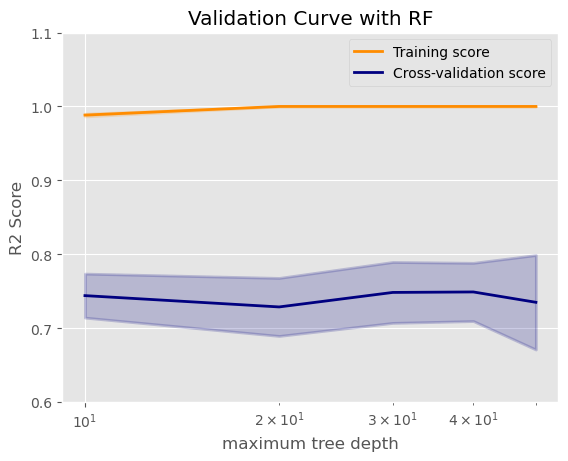

In [47]:
# plotting the validation curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve with RF")
plt.xlabel(r"maximum tree depth")
plt.ylabel("R2 Score")
plt.ylim(0.6, 1.1)
lw = 2
plt.semilogx(max_depth_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(max_depth_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(max_depth_range, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(max_depth_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [48]:
dt_final = DecisionTreeRegressor(max_depth=clf.best_params_['max_depth'], random_state=randomState_dt)
dt_final.fit(train_x, train_y)

DecisionTreeRegressor(max_depth=10, random_state=10000)

In [49]:
print('The score on the training data:')
print(dt_final.score(train_x, train_y))
print('The score on the testing data:')
print(dt_final.score(test_x, test_y))

The score on the training data:
0.9890472695830228
The score on the testing data:
0.7350074821879649
